In [1]:
import gym
import gym.envs.toy_text
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
env = gym.envs.toy_text.CliffWalkingEnv()

In [4]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [5]:
print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [6]:
n_actions = env.action_space.n
n_states = env.observation_space.n
print(f'Number of actions : {n_actions}')
print(f'Number of states : {n_states}')

Number of actions : 4
Number of states : 48


# Creating an agent

In [7]:
class MonteCarloAgent:
    def __init__(self, n_actions, n_states, epsilon=1,
                exploring_starts=False):
        self.n_actions = n_actions
        if exploring_starts:
            self.q_table = np.full(shape=(n_states,n_actions),fill_value=5)
            self.epsilon = 0
        else:
            self.q_table = np.zeros(shape=(n_states,n_actions))
            self.epsilon = epsilon
        self.frequency_table = np.zeros(shape=(n_states,n_actions))
        
    
    def argmax(self,q_table):
        max_value = np.max(q_table)
        idxs = np.where(q_table==max_value)[0]
        if idxs.shape[0]>1:
            return np.random.choice(idxs)
        else:
            print('made argmax')
            return np.argmax(q_table)
    
    def get_action(self,state):
        if np.random.rand()<self.epsilon:
            action = np.random.choice(range(self.n_actions))
        else:
            action = np.argmax(self.q_table[state])
        return action
        
    
    def update(self, state, action, discounted_return):
        self.frequency_table[state,action]+=1
        self.q_table[state,action]+=(1/self.frequency_table[state,action])*(discounted_return-self.q_table[state,action])
        

# Training an agent

In [8]:
agent = MonteCarloAgent(n_actions,n_states,exploring_starts=False,epsilon=0.15)

In [9]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

def show_progress(reward_per_episode,steps_per_episode):
    clear_output(True)
    fig, ax = plt.subplots(3,1)
    ax[0].plot(reward_per_episode,label='reward per episode')
    ax[0].legend()
    ax[0].set_ylim(-1000,0)
    ax[1].plot(steps_per_episode, label = 'steps per episode')
    ax[1].legend()
    ax[2].plot(moving_average(reward_per_episode), label='moving reward')
    ax[2].legend()
    ax[2].set_ylim(-1000, 0)
    fig.tight_layout() 
    plt.show()
    
def generate_episode(agent,env, t_max=10**4, render=False):
    s = env.reset()
    states = []
    actions = []
    rewards = []
    steps = 0
    for t in range(t_max):
        a = agent.get_action(s)
        new_s, r, done, _ = env.step(a)
        actions.append(a)
        rewards.append(r)
        states.append(s)
        s = new_s
        if render:
            clear_output(True)
            env.render()
        if done:
            break
        steps+=1
    return states, actions, rewards, steps
    

def train_loop(env, agent, gamma=1, n_episodes=1000, epsilon_discount=False):
    returns = np.zeros(shape=(n_states,n_actions))
    reward_per_episode = []
    steps_per_episode = []
    for episode in range(1,n_episodes+1):
        if epsilon_discount:
            agent.epsilon*=0.99
        states,actions, rewards, steps = generate_episode(agent,env)
        reward_per_episode.append(np.sum(rewards))
        steps_per_episode.append(steps)
        return_from_episode = 0
        counter = 0 
        for s,a,r in list(zip(states,actions,rewards))[::-1]:
            return_from_episode+=r*(gamma**counter)
            returns[s,a]+=return_from_episode
            agent.update(s,a,returns[s,a])
            counter+=1
        if episode%100==0:
            show_progress(reward_per_episode,steps_per_episode)
            print(f'Reward sum : {np.sum(rewards)}')
            print(f'Mean reward : {np.mean(reward_per_episode[-100:])}')
            print(f'agent.epsilon : {agent.epsilon}')

    return agent

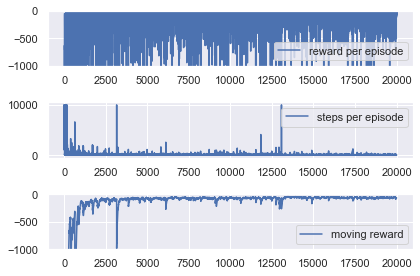

Reward sum : -24
Mean reward : -76.03
agent.epsilon : 0.15


In [10]:
agent = train_loop(env,agent,1,20000, False)

# Showing the trajectory learned by agent

In [11]:
agent.epsilon = 0

In [12]:
states,actions, rewards, steps = generate_episode(agent,env,render=False)
steps

10000

In [13]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_action(yi * n_cols + xi)], end='')
        print()

In [117]:
draw_policy(env,agent)

 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  v  >  v  >  <  >  >  >  >  v  v 
 ^  >  >  >  ^  v  v  <  >  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
